In [1]:
import pf
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import time
from numba import njit, prange
from tqdm import tqdm
import numba
from numba import cuda

In [2]:
plt.style.use('default')

In [2]:
def gpu_solver(S,I,lamb,tstep=.01,t_max =10000):
    fS = cp.zeros_like(S)
    fI = cp.zeros_like(I)
    for t in range(t_max):
        pf.forces(S,I,lamb,cp.shape(S)[1],fS,fI)
        S = S + tstep*fS
        I = I + tstep*fI 
        S[:,0] = S[:,-1] = I[:,0] = I[:,-1] = 0
    return S,I

def cpu_solver(S,I,lamb,tstep=.01,t_max =1000):
    Ly,Lx = S.shape
    S = S.reshape(Ly*Lx)
    I = I.reshape(Ly*Lx)
    lamb = lamb.reshape(Ly*Lx)
    fS = np.zeros_like(S)
    fI = np.zeros_like(I)
    for t in range(t_max):
        for i in range(Lx*Ly):
            x = i % Lx
            y = i // Lx
            fS[i] = -S[i]*I[i] + S[(x+1)%Lx + Lx*y] + S[(x-1+Lx)%Lx+Lx*y] + S[x + Lx*((y+1)%Ly)] + S[x + Lx*((y-1+Ly)%Ly)] - 4*S[i]
            fI[i] = S[i]*I[i] - lamb[i]*I[i] + I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx+Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i]
        S = S + tstep*fS
        I = I + tstep*fI
        S[::Lx] = S[Lx-1::Lx] = I[::Lx] = I[Lx-1::Lx] = 0
    return S.reshape(Ly,Lx),I.reshape(Ly,Lx)

@njit(parallel=True)
def cpu_numba_solver(S,I,lamb,tstep=.01,t_max =1000):
    Ly,Lx = S.shape
    S = S.reshape(Ly*Lx)
    I = I.reshape(Ly*Lx)
    lamb = lamb.reshape(Ly*Lx)
    fS = np.zeros_like(S)
    fI = np.zeros_like(I)
    for t in range(t_max):
        for i in prange(Lx*Ly):
            x = i % Lx
            y = i // Lx
            fS[i] = -S[i]*I[i] + S[(x+1)%Lx + Lx*y] + S[(x-1+Lx)%Lx+Lx*y] + S[x + Lx*((y+1)%Ly)] + S[x + Lx*((y-1+Ly)%Ly)] - 4*S[i]
            fI[i] = S[i]*I[i] - lamb[i]*I[i] + I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx+Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i]
        S = S + tstep*fS
        I = I + tstep*fI
        S[::Lx] = S[Lx-1::Lx] = I[::Lx] = I[Lx-1::Lx] = 0
    return S.reshape(Ly,Lx),I.reshape(Ly,Lx)


In [18]:
p, l = 0, .2
N_max = 1024
gpu_time = np.array([])
N_vec = np.array([])
for L in tqdm(range(400,N_max,100)):
    lamb = cp.random.choice([0,l],size=(L,L),p = [p,1-p])
    S = cp.ones((L,L))
    I = cp.zeros((L,L))
    S[:,1] = cp.zeros_like(S[:,1])
    I[:,1] = cp.ones_like(I[:,1])
    s = time.time()
    gpu_solver(S,I,lamb,t_max=10000)
    cuda.synchronize()
    e = time.time()
    gpu_time = np.append(gpu_time,e-s)
    N_vec = np.append(N_vec,L)
np.save('gpu_time_2',gpu_time)
np.save('N_gpu_2',N_vec)

100%|██████████| 7/7 [00:26<00:00,  3.76s/it]


In [16]:
L = 1024
p = 0
l = .2
lamb = np.random.choice([0,l],size=(L,L),p = [p,1-p])
S = np.ones((L,L))
I = np.zeros((L,L))
S[:,1] = np.zeros_like(S[:,1])
I[:,1] = np.ones_like(I[:,1])
a = cpu_numba_solver(S,I,lamb,t_max=1000)[1]

In [6]:
L = 1024
p = 0
l = .2
lamb = cp.random.choice([0,l],size=(L,L),p = [p,1-p])
S = cp.ones((L,L))
I = cp.zeros((L,L))
S[:,1] = cp.zeros_like(S[:,1])
I[:,1] = cp.ones_like(I[:,1])
b = gpu_solver(S,I,lamb,t_max=10000)[1]

In [57]:
p, l = 0, .2
N_max = 1024
cpu_time = np.array([])
N_vec = np.array([])
for L in tqdm(range(400,N_max,100)):
    lamb = np.random.choice([0,l],size=(L,L),p = [p,1-p])
    S = np.ones((L,L))
    I = np.zeros((L,L))
    S[:,1] = np.zeros_like(S[:,1])
    I[:,1] = np.ones_like(I[:,1])
    s = time.time()
    cpu_numba_solver(S,I,lamb,t_max=10000)
    e = time.time()
    cpu_time = np.append(cpu_time,e-s)
    N_vec = np.append(N_vec,L)
np.save('cpu_time_2',cpu_time)
np.save('N_cpu_2',N_vec)

100%|██████████| 7/7 [12:51<00:00, 110.15s/it]


Text(0, 0.5, '$t_{cpu}/t_{gpu}$ [s]')

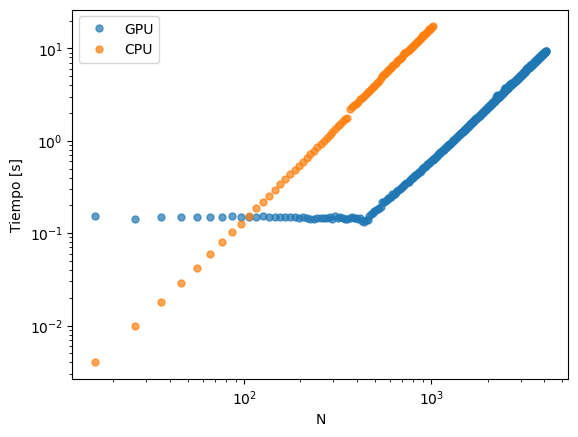

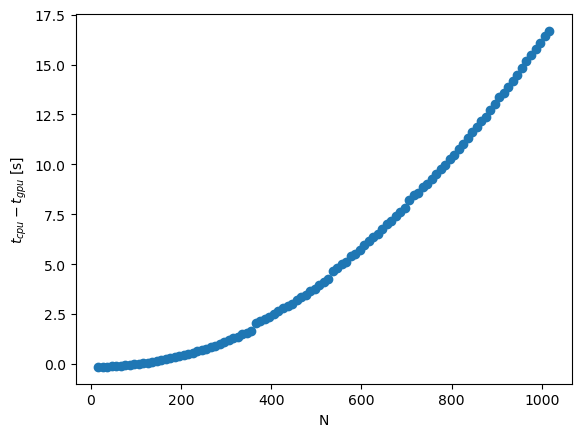

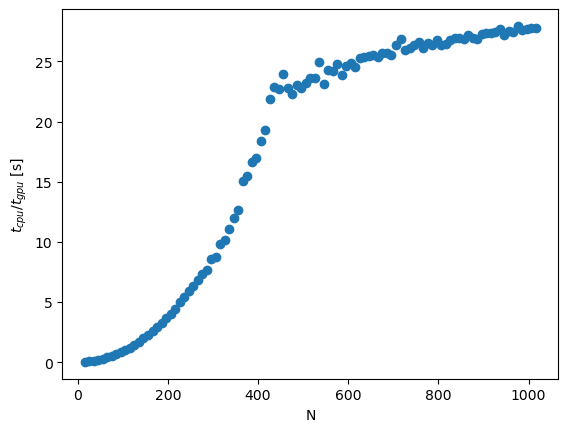

In [64]:
gpu_time = np.load('gpu_time.npy')
gpu_N = np.load('N_gpu.npy')
cpu_time = np.load('cpu_time.npy')
cpu_N = np.load('N_vec.npy')
delta = cpu_time - gpu_time[gpu_N <= cpu_N[-1]]
ratio = cpu_time/gpu_time[gpu_N <= cpu_N[-1]]


plt.figure()
plt.loglog(gpu_N,gpu_time,'o',label='GPU',alpha=.7,markersize=5)
plt.loglog(cpu_N,cpu_time,'o',label='CPU',alpha=.7,markersize=5)
plt.xlabel('N')
plt.ylabel('Tiempo [s]')
plt.legend(loc=2)

plt.figure()
plt.plot(cpu_N,delta,'o')
plt.xlabel('N')
plt.ylabel('$t_{cpu}-t_{gpu}$ [s]')
plt.figure()
plt.plot(cpu_N,ratio,'o')
plt.xlabel('N')
plt.ylabel('$t_{cpu}/t_{gpu}$ [s]')

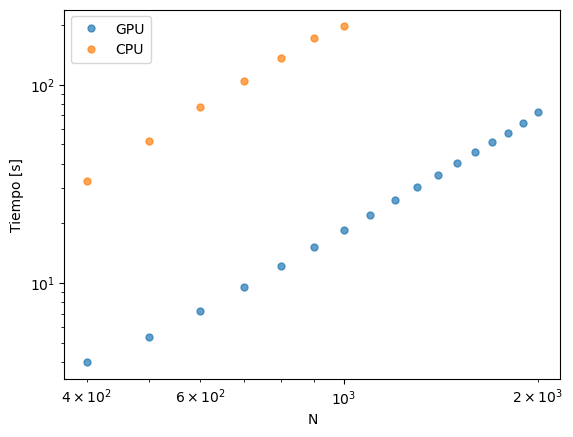

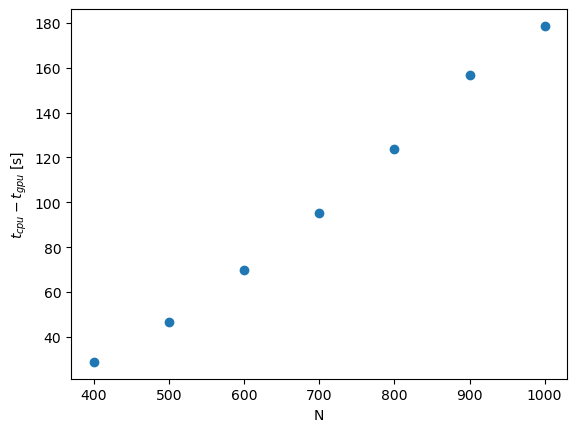

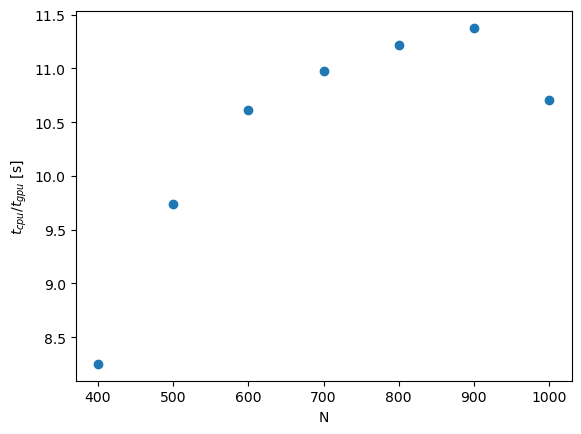

In [61]:
gpu_time = np.load('gpu_time_2.npy')
gpu_N = np.load('N_gpu_2.npy')
cpu_time = np.load('cpu_time_2.npy')
cpu_N = np.load('N_cpu_2.npy')
delta = cpu_time - gpu_time[gpu_N <= cpu_N[-1]]
ratio = cpu_time/gpu_time[gpu_N <= cpu_N[-1]]

plt.figure()
plt.loglog(gpu_N,gpu_time,'o',label='GPU',alpha=.7,markersize=5)
plt.loglog(cpu_N,cpu_time,'o',label='CPU',alpha=.7,markersize=5)
plt.xlabel('N')
plt.ylabel('Tiempo [s]')
plt.legend(loc=2)

plt.figure()
plt.plot(cpu_N,delta,'o')
plt.xlabel('N')
plt.ylabel('$t_{cpu}-t_{gpu}$ [s]')
plt.figure()
plt.plot(cpu_N,ratio,'o')
plt.xlabel('N')
plt.ylabel('$t_{cpu}/t_{gpu}$ [s]')
plt.show()